In [1]:
from src.util import gpu_setup
gpu_setup()

10 actual GPUs, 1 in use.


In [2]:
cd ..

/home/mars/src_aiai


In [3]:
import numpy as  np
import matplotlib.pyplot as plt
from astropy.io import fits

In [4]:
from scipy.ndimage import gaussian_filter


In [5]:
fits.getheader("./data/M51.fits")


SIMPLE  =                    T / Written by SkyView Mon Apr 13 19:07:00 EDT 2020
BITPIX  =                  -32 / 4 byte floating point                          
NAXIS   =                    2 / Two dimensional image                          
NAXIS1  =                  256 / Width of image                                 
NAXIS2  =                  256 / Height of image                                
CRVAL1  =   202.46957500000002 / Reference longitude                            
CRVAL2  =    47.19525800000001 / Reference latitude                             
RADESYS = 'FK5     '           / Coordinate system                              
EQUINOX =               2000.0 / Epoch of the equinox                           
CTYPE1  = 'RA---TAN'           / Coordinates -- projection                      
CTYPE2  = 'DEC--TAN'           / Coordinates -- projection                      
CRPIX1  =                128.5 / X reference pixel                              
CRPIX2  =                128

In [6]:
im2 = fits.getdata("./data/M51.fits")

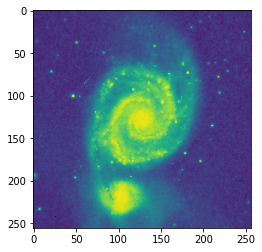

In [7]:
plt.imshow(np.log(im2))

In [8]:
im2.max(), im2.min()

(13980.0, 2376.0)

In [9]:
x_true = gaussian_filter(im2, 1)
x_true = (x_true -  x_true.min())/(x_true.max() - x_true.min())

# load model

In [10]:
import os
import tensorflow as tf
from src.networks.UNet import UNet
from src.networks.GUnet import GUnet

In [11]:
from src.operators.NUFFT2D_TF import NUFFT2D_TF
from src.sampling.uv_sampling import spider_sampling

In [12]:
operator = "NUFFT_SPIDER"
data = "TNG"
ISNR = 30
project_folder = os.environ["HOME"] + "/src_aiai/"
data_folder = project_folder + f"data/intermediate/{data}/{operator}/"

In [13]:
Nd =(256,256)
Kd = (512, 512)
Jd = (6,6)
batch_size = 1

uv = spider_sampling()
m_op = NUFFT2D_TF()
m_op.plan(uv, Nd, Kd, Jd, batch_size)


100%|██████████| 4440/4440 [00:00<00:00, 4916.61it/s]


In [14]:
def calc_w(uv):
    grid_cell = 2*np.pi /512 
    binned = (uv[:,:]+np.pi+.5*grid_cell) // grid_cell
    binned = [tuple(x) for x in binned]
    w_gridded = np.zeros(uv.shape[0])

    d = {}
    for i in (binned):
        if i in d:
            d[i] += 1
        else:
            d[i] = 1

    for i in range(len(w_gridded)):
        w_gridded[i] = d[binned[i]]
    # w = 
    w = 1/w_gridded
    w /= w.max()
    return w

w = calc_w(uv)

In [15]:
unet = UNet(
    Nd, 
    uv=uv,
    op=NUFFT2D_TF, 
    depth=4, 
    conv_layers=2,
    input_type="measurements", 
    measurement_weights=w,
    batch_size=batch_size,
    residual=True
    )

100%|██████████| 4440/4440 [00:00<00:00, 4862.78it/s]


KerasTensor(type_spec=TensorSpec(shape=(None, 4440), dtype=tf.complex64, name='input_1'), name='input_1', description="created by layer 'input_1'") KerasTensor(type_spec=TensorSpec(shape=(1, 256, 256), dtype=tf.float32, name=None), name='tf.__operators__.add/AddV2:0', description="created by layer 'tf.__operators__.add'")


In [16]:
data = "TNG"
network = "UNet"
postfix = "_transfer"
checkpoint_folder = project_folder+ f"models/{data}/{operator}/{network}_{ISNR}dB{postfix}"
latest = tf.train.latest_checkpoint(checkpoint_folder)
unet.load_weights(latest)

In [17]:
unet_coco = UNet(
    Nd, 
    uv=uv,
    op=NUFFT2D_TF, 
    depth=4, 
    conv_layers=2,
    input_type="measurements", 
    measurement_weights=w,
    batch_size=batch_size,
    residual=True
    )

100%|██████████| 4440/4440 [00:00<00:00, 5583.68it/s]


KerasTensor(type_spec=TensorSpec(shape=(None, 4440), dtype=tf.complex64, name='input_2'), name='input_2', description="created by layer 'input_2'") KerasTensor(type_spec=TensorSpec(shape=(1, 256, 256), dtype=tf.float32, name=None), name='tf.__operators__.add_1/AddV2:0', description="created by layer 'tf.__operators__.add_1'")


In [18]:
data = "COCO"
network = "UNet"
postfix = ""
checkpoint_folder = project_folder+ f"models/{data}/{operator}/{network}_{ISNR}dB{postfix}"
latest = tf.train.latest_checkpoint(checkpoint_folder)
unet_coco.load_weights(latest)

In [21]:
gunet = GUnet(
    Nd, 
    uv=uv,
    op=NUFFT2D_TF, 
    depth=4, 
    conv_layers=2,
    input_type="measurements", 
    measurement_weights=w,
    batch_size=batch_size,
    residual=True
    )


100%|██████████| 4439/4439 [00:00<00:00, 5829.34it/s]


some values lie out of the interpolation array, these are not used, check baselines


100%|██████████| 3858/3858 [00:00<00:00, 5835.13it/s]


some values lie out of the interpolation array, these are not used, check baselines


100%|██████████| 2830/2830 [00:00<00:00, 5877.45it/s]


some values lie out of the interpolation array, these are not used, check baselines


100%|██████████| 2140/2140 [00:00<00:00, 5886.68it/s]


some values lie out of the interpolation array, these are not used, check baselines
KerasTensor(type_spec=TensorSpec(shape=(None, 4440), dtype=tf.complex64, name='input_4'), name='input_4', description="created by layer 'input_4'") KerasTensor(type_spec=TensorSpec(shape=(1, 256, 256), dtype=tf.float32, name=None), name='tf.__operators__.add_3/AddV2:0', description="created by layer 'tf.__operators__.add_3'")


In [22]:
data="TNG"
network = "GUnet"
postfix = "_transfer"
checkpoint_folder = project_folder+ f"models/{data}/{operator}/{network}_{ISNR}dB{postfix}"
latest = tf.train.latest_checkpoint(checkpoint_folder)
gunet.load_weights(latest)

In [23]:
gunet_coco = GUnet(
    Nd, 
    uv=uv,
    op=NUFFT2D_TF, 
    depth=4, 
    conv_layers=2,
    input_type="measurements", 
    measurement_weights=w,
    batch_size=batch_size,
    residual=True
    )

100%|██████████| 4439/4439 [00:00<00:00, 5795.86it/s]


some values lie out of the interpolation array, these are not used, check baselines


100%|██████████| 3858/3858 [00:00<00:00, 5685.19it/s]


some values lie out of the interpolation array, these are not used, check baselines


100%|██████████| 2830/2830 [00:00<00:00, 5889.42it/s]


some values lie out of the interpolation array, these are not used, check baselines


100%|██████████| 2140/2140 [00:00<00:00, 5881.25it/s]


some values lie out of the interpolation array, these are not used, check baselines
KerasTensor(type_spec=TensorSpec(shape=(None, 4440), dtype=tf.complex64, name='input_5'), name='input_5', description="created by layer 'input_5'") KerasTensor(type_spec=TensorSpec(shape=(1, 256, 256), dtype=tf.float32, name=None), name='tf.__operators__.add_4/AddV2:0', description="created by layer 'tf.__operators__.add_4'")


In [24]:
data="COCO"
network = "GUnet"
postfix = "" #"_transfer"
checkpoint_folder = project_folder+ f"models/{data}/{operator}/{network}_{ISNR}dB{postfix}"
latest = tf.train.latest_checkpoint(checkpoint_folder)
gunet_coco.load_weights(latest)

# measurements

In [25]:
y0 = m_op.dir_op(x_true)

In [26]:
ISNR=30
sigma = np.sqrt(np.mean(np.abs(y0)**2)) * 10**(-ISNR/20)
n = np.random.normal( 0, sigma, y0.shape) + 1j * np.random.normal( 0, sigma, y0.shape)
y = y0 + n/np.sqrt(2) # correct for the complex amplitude of noise

In [27]:
x_dirty = m_op.adj_op(y*w)

In [28]:
x_unet = unet(tf.reshape(y, (1,-1)))
x_gunet = gunet(tf.reshape(y, (1,-1)))

x_unet_coco = unet_coco(tf.reshape(y, (1,-1)))
x_gunet_coco = gunet_coco(tf.reshape(y, (1,-1)))


In [29]:
from skimage.metrics import structural_similarity, peak_signal_noise_ratio, mean_squared_error

def compare_multiple(images, ncols=None, nrows=None, titles=None, same_scale=False, colorbar=False, cmap='viridis', save_base="./plots/example", cbar_anchor=(1.2, 0), rot=0, vmin=None, vmax=None, ylabel=""):
    """[summary]
    TODO add colorbars
    Args:
        images ([type]): [description]
        ncols ([type], optional): [description]. Defaults to None.
        nrows ([type], optional): [description]. Defaults to None.
        titles ([type], optional): [description]. Defaults to None.
        same_scale (bool, optional): [description]. Defaults to False.
    """

    if not nrows:
        nrows = 1
    if not ncols:
        ncols = 1
    if ncols*nrows < len(images):
        ncols = len(images)
        nrows = 1
    if not titles:
        titles = [""]*len(images)
    
    images = [np.rot90(i, rot) for i in images]
    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, 
        figsize=(ncols*6, nrows*6 +1), squeeze=False)

    a = ax[0,0].imshow(images[0])    
    ax[0,0].set_title(titles[0])
    ax[0,0].set_ylabel(ylabel)
    if vmin is None:
        vmin, vmax = a.get_clim()
    for i in range(0, nrows):
        for j in range(ncols):
            if i +j*nrows >= len(images):
                break
            if same_scale:
                im = ax[i,j].imshow(images[j + i*ncols], 
                    vmin=vmin, vmax=vmax, cmap=cmap)
            else:
                im = ax[i,j].imshow(images[j + i*ncols], cmap=cmap)
            if j % ncols != 0:
                if titles[j + i*ncols]:
                    ax[i,j].set_title(titles[j + i*ncols] + f"\n(PSNR: {peak_signal_noise_ratio(images[i*ncols], images[j + i*ncols]):.2f}dB)" ) 
                else:
                    ax[i,j].set_title(f"(PSNR: {peak_signal_noise_ratio(images[i*ncols], images[j + i*ncols]):.2f}dB)" ) 
                    
            else:
                if titles[j + i*ncols]:
                    ax[i,j].set_title(titles[j + i*ncols] +"\n")
                else:
                    ax[i,j].set_title(titles[j + i*ncols])
                    
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
    if colorbar:
#         plt.colorbar(im, ax=ax, anchor=cbar_anchor, shrink=.8)
        plt.colorbar(im, ax=ax,anchor=cbar_anchor, fraction=0.046, pad=0.04, shrink=.87)
    plt.subplots_adjust(wspace=.01)

In [30]:
from src.solvers import PrimalDual_l1_constrained
from src.operators.dictionary import wavelet_basis

In [31]:
psi = wavelet_basis(x_true.shape, wavelets=["db8", "db7", "db6", "db5", "db4", "db3", "db2", "db1", "dirac"], levels=3)
solver = PrimalDual_l1_constrained(m_op=m_op, psi=psi, beta=1e-5,
    options={
        'tol': 1e-6, 'iter': 300, 'update_iter': 50, 
        'record_iters': False, 'positivity': True, 'real': True})


{'tol': 1e-06, 'iter': 300, 'update_iter': 50, 'record_iters': False, 'positivity': True, 'real': True}


In [32]:
from src.operators.NUFFT2D import NUFFT2D
Nd =(256,256)
Kd = (512, 512)
Jd = (6,6)
batch_size = 1

uv = spider_sampling()
m_op2 = NUFFT2D()
m_op2.plan(uv, Nd, Kd, Jd, batch_size)

100%|██████████| 4440/4440 [00:00<00:00, 5019.50it/s]


In [33]:
y2 = y.numpy().flatten()

In [34]:
a = solver.solve(y2, m_op2, sigma)

2023-09-21 16:20:07,044 - Optimus Primal - INFO - Starting Power method
2023-09-21 16:20:07,251 - Optimus Primal - INFO - [Power Method] iter = 1, tol = 0.0
2023-09-21 16:20:08,258 - Optimus Primal - INFO - [Power Method] iter = 11, tol = 0.0
2023-09-21 16:20:08,459 - Optimus Primal - INFO - [Power Method] Converged with norm= 5.733112755291694, iter = 13, tol = 0.0008499898251589261
2023-09-21 16:20:08,611 - Optimus Primal - INFO - Running Forward Backward Primal Dual
2023-09-21 16:20:08,844 - Optimus Primal - INFO - [Primal Dual] 0 out of 300 iterations, tol = 0.721830
2023-09-21 16:20:20,030 - Optimus Primal - INFO - [Primal Dual] 50 out of 300 iterations, tol = 0.007216
2023-09-21 16:20:31,182 - Optimus Primal - INFO - [Primal Dual] 100 out of 300 iterations, tol = 0.000861
2023-09-21 16:20:41,749 - Optimus Primal - INFO - [Primal Dual] 150 out of 300 iterations, tol = 0.000096
2023-09-21 16:20:51,792 - Optimus Primal - INFO - [Primal Dual] 200 out of 300 iterations, tol = 0.000094

In [31]:
a2 = solver.solve(y2*w, m_op2, sigma)

2023-08-29 16:28:32,481 - Optimus Primal - INFO - Starting Power method
2023-08-29 16:28:32,756 - Optimus Primal - INFO - [Power Method] iter = 1, tol = 0.0
2023-08-29 16:28:34,117 - Optimus Primal - INFO - [Power Method] iter = 11, tol = 0.0
2023-08-29 16:28:34,363 - Optimus Primal - INFO - [Power Method] Converged with norm= 5.730942339232025, iter = 13, tol = 0.0008581604376006528
2023-08-29 16:28:34,517 - Optimus Primal - INFO - Running Forward Backward Primal Dual
2023-08-29 16:28:34,767 - Optimus Primal - INFO - [Primal Dual] 0 out of 300 iterations, tol = 0.675169
2023-08-29 16:28:47,475 - Optimus Primal - INFO - [Primal Dual] 50 out of 300 iterations, tol = 0.010897
2023-08-29 16:29:02,066 - Optimus Primal - INFO - [Primal Dual] 100 out of 300 iterations, tol = 0.006799
2023-08-29 16:29:17,426 - Optimus Primal - INFO - [Primal Dual] 150 out of 300 iterations, tol = 0.004001
2023-08-29 16:29:32,791 - Optimus Primal - INFO - [Primal Dual] 200 out of 300 iterations, tol = 0.002711

/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.


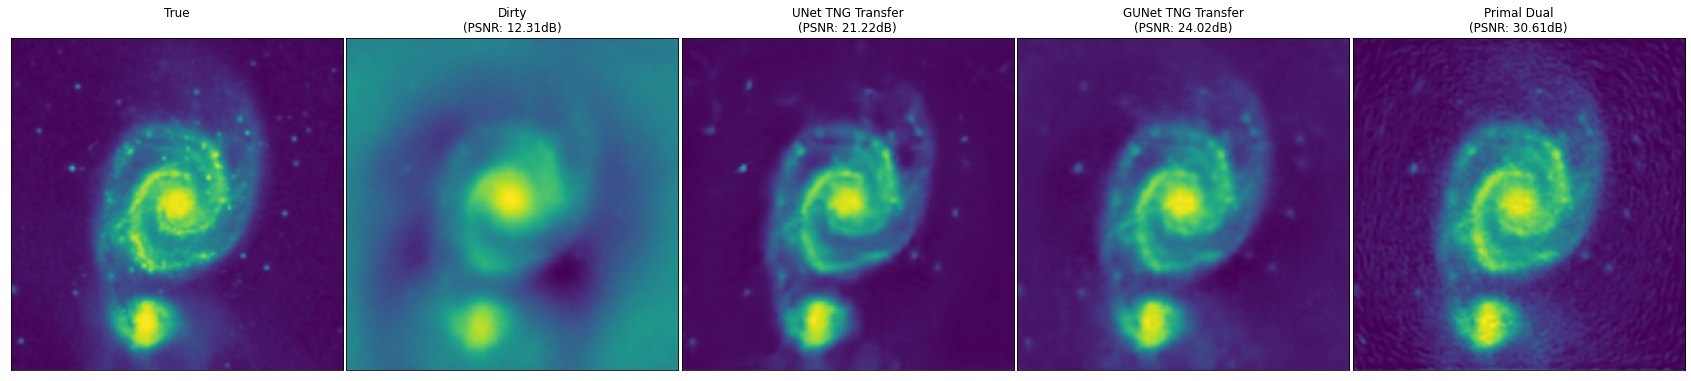

In [35]:
compare_multiple([x_true.real, x_dirty[0].numpy().real, x_unet[0].numpy().real, x_gunet[0].numpy().real, a[0].real], titles=["True", "Dirty", "UNet TNG Transfer", "GUNet TNG Transfer", "Primal Dual"])
plt.savefig("./plots/compare_dss_TNG.pdf")

/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.


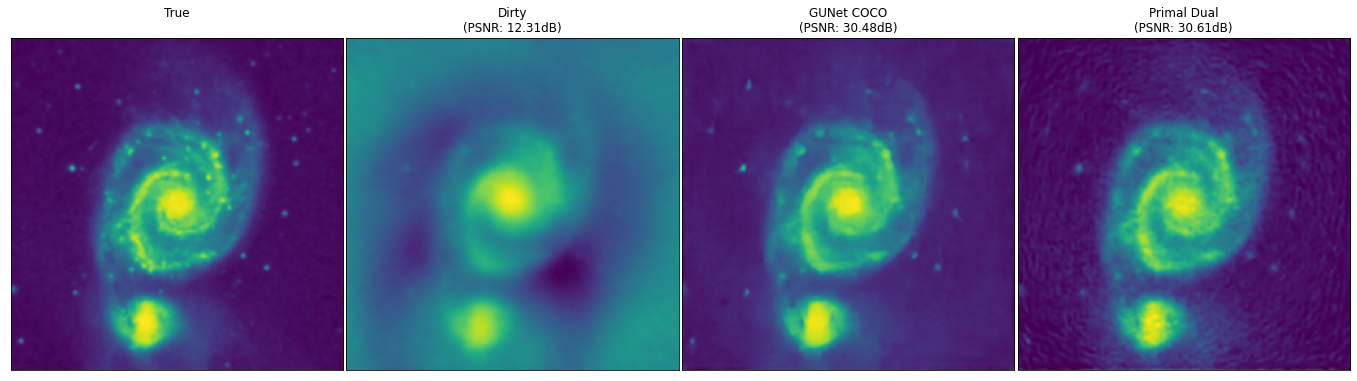

In [38]:
compare_multiple([x_true.real, x_dirty[0].numpy().real, x_gunet_coco[0].numpy().real, a[0].real], titles=["True", "Dirty", "GUNet COCO", "Primal Dual"])
# plt.savefig("./plots/compare_dss_COCO.pdf")
plt.savefig("./plots/compare_dss_COCO.png", bbox_inches='tight')

/home/mars/.conda/envs/InterferAI/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.


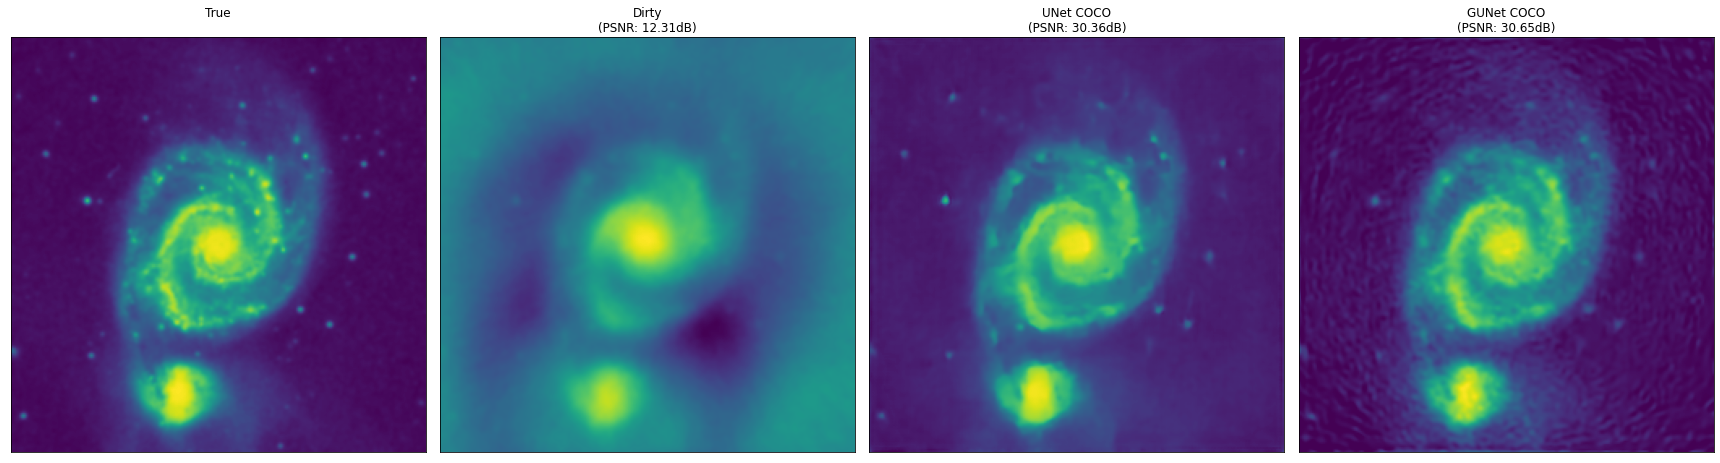

In [36]:
compare_multiple([x_true.real, x_dirty[0].numpy().real, x_gunet_coco[0].numpy().real, a[0].real], titles=["True", "Dirty", "UNet COCO", "GUNet COCO", "Primal Dual"])
# plt.savefig("./plots/compare_dss_COCO.pdf")
plt.tight_layout()
plt.savefig("./plots/compare_dss_COCO2.png")